## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
# Load the labels CSV file
labels_df = pd.read_csv('/datasets/faces/labels.csv')
print("Labels CSV shape:", labels_df.shape)
print(labels_df.head())


Labels CSV shape: (7591, 2)
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


In [3]:
# Create an ImageDataGenerator that rescales pixel values by dividing them by 255.
datagen = ImageDataGenerator(rescale=1/255.)


In [4]:
# Build a generator to read the images sequentially.
image_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files/',  # folder containing the images
    x_col='file_name',                          # column with image file names
    y_col='real_age',                           # column with the age labels
    target_size=(150, 150),                     # resize images to 150x150
    batch_size=32,                              # number of images per batch
    class_mode='raw',                           # 'raw' returns the age values as-is (for regression)
    shuffle=False                               # set to False if you want to keep the order for analysis
)

Found 7591 validated image filenames.


## EDA

In [5]:
# Dataset Overview: Print total number of samples and descriptive statistics for the real_age column.
print("Total number of samples:", labels_df.shape[0])
print("\nAge Statistics:")
print(labels_df['real_age'].describe())


Total number of samples: 7591

Age Statistics:
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


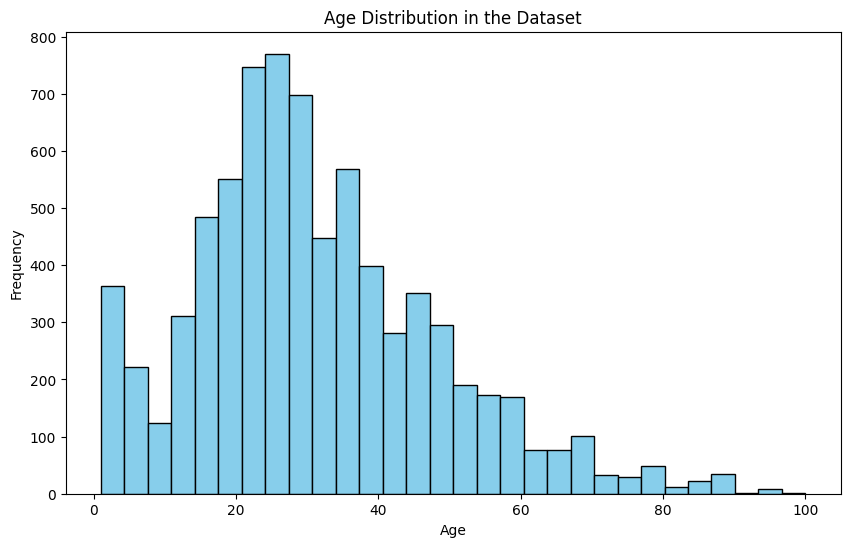

In [6]:
# Age Distribution: Plot a histogram of the ages.
plt.figure(figsize=(10,6))
plt.hist(labels_df['real_age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution in the Dataset")
plt.show()


In [7]:
# Display Sample Images
features, target = next(image_generator)


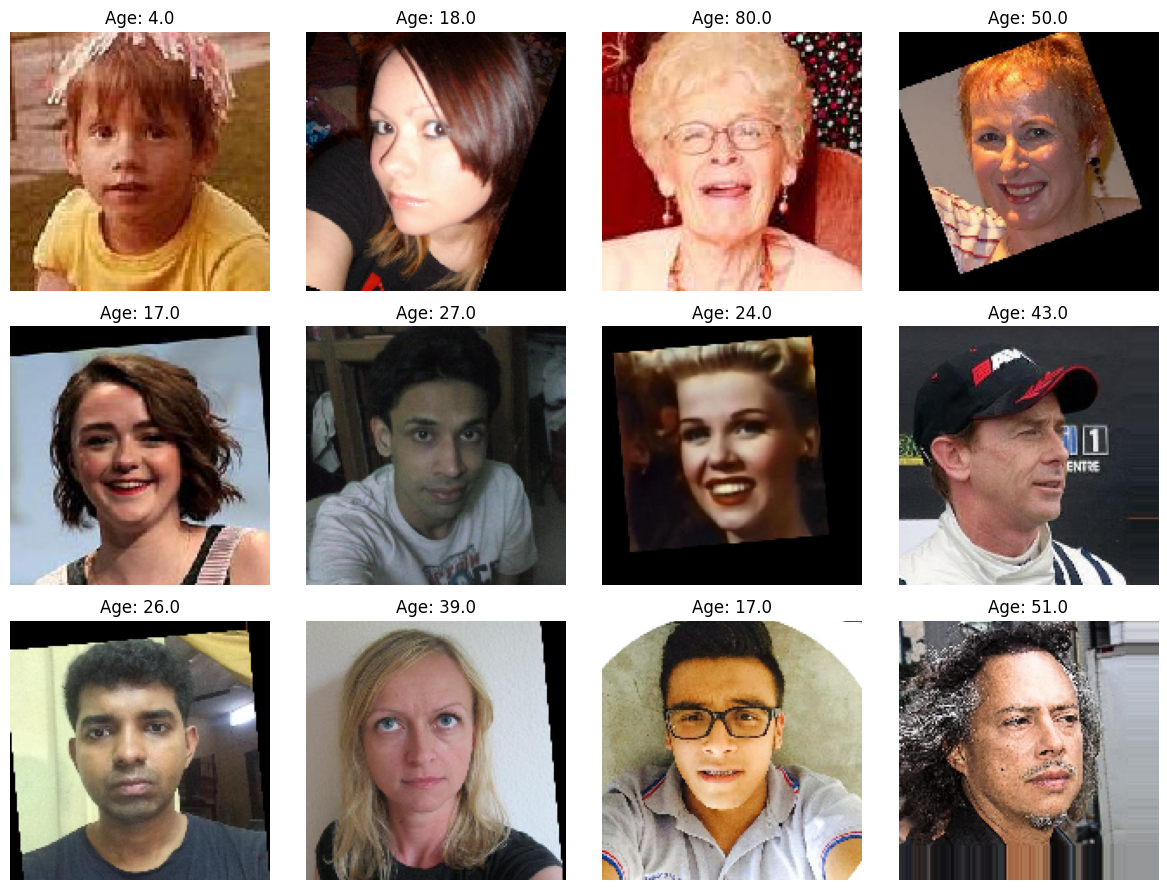

In [8]:
# Create a grid to display 12 sample images
fig, axes = plt.subplots(3, 4, figsize=(12,9))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(features[i])
    axes[i].set_title(f"Age: {target[i]:.1f}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()


## Findings from the Exploratory Data Analysis

**Total Number of Samples:**  
- 7591 images

**Age Statistics:**  
- **Count:** 7591  
- **Mean:** 31.20  
- **Standard Deviation:** 17.15  
- **Minimum Age:** 1  
- **25th Percentile:** 20  
- **Median Age:** 29  
- **75th Percentile:** 41  
- **Maximum Age:** 100  

**Observations on the Age Distribution:**  
- The dataset covers a wide range of ages from 1 to 100.  
- A majority of the samples appear to be in the younger to middle-age range (approximately 20–29 years).  
- There are relatively fewer examples at the extreme age ranges (very young or very old).

**Implications for Model Training:**  
- The wide age range may pose a challenge to the model if it does not see enough examples of very young or very old faces.  
- Since most images are concentrated in the lower to middle age ranges, the model might exhibit bias towards these age groups.  
- It may be beneficial to consider data augmentation or rebalancing strategies if further analysis confirms a significant imbalance across age groups.


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # Load the labels CSV
    labels_df = pd.read_csv(path + "/labels.csv")    
    
    # Create an ImageDataGenerator with rescaling and a 25% validation split
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    
    # Build training generator using the "training" subset
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + "/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(150, 150),
        batch_size=32,
        class_mode="raw",
        subset="training",
        shuffle=True,
        seed=12345
    )
    return train_gen_flow


In [11]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    # Load the labels CSV file
    labels_df = pd.read_csv(path + "/labels.csv")
    
    # Create an ImageDataGenerator with rescaling and a validation split of 0.25.
    datagen = ImageDataGenerator(rescale=1/255., validation_split=0.25)
    
    # Build the test generator using the "validation" subset.
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels_df,
        directory=path + "/final_files",
        x_col="file_name",
        y_col="real_age",
        target_size=(150, 150),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        shuffle=False,
        seed=12345
    )
    return test_gen_flow   


In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    # Load ResNet50 without its top classification layers, with ImageNet weights
    base = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # Freeze the base so its pre-trained weights are not updated during training
    base.trainable = False

    # Build the model
    model = Sequential()
    model.add(base)
    model.add(GlobalAveragePooling2D())
    # Add a small dense head
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    # Final regression output: single neuron, ReLU to ensure non-negative age
    model.add(Dense(1, activation='relu'))

    # Compile for regression with MSE loss and Adam optimizer
    model.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['mae']
    )
    return model


In [13]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_data,
        validation_steps=validation_steps,
        verbose=2
    )
    return model


### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [14]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')
        
print("Script 'run_model_on_gpu.py' has been created.")

Script 'run_model_on_gpu.py' has been created.


### Output

Place the output from the GPU platform as an Markdown cell here.

Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-04-11 23:33:01.324550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
94773248/94765736 [==============================] - 1s 0us/step
94781440/94765736 [==============================] - 1s 0us/step
1/1 - 9s - loss: 1462.5374 - mae: 32.7548 - val_loss: 974.6562 - val_mae: 24.9688 - 9s/epoch - 9s/step
<keras.callbacks.History at 0x7ff399121fd0>

## Conclusion of Initial GPU Training

- **Data Loading:**  
  - Successfully validated 5,694 training images and 1,897 validation images via `ImageDataGenerator`.
  - Images were rescaled to [0, 1] and resized to 150×150 pixels.

- **Model Architecture:**  
  - Employed a frozen ResNet50 backbone (ImageNet‑pretrained) with a custom regression head:  
    - Global average pooling → Dense(256, ReLU) → Dropout(0.5) → Dense(1, ReLU).

- **Training Setup:**  
  - Ran a quick sanity check: 1 epoch, 1 training step, and 1 validation step.  
  - Loss function: Mean Squared Error (MSE).  
  - Metric: Mean Absolute Error (MAE).

- **Observed Metrics:**  
  - **Training loss (MSE):** 1462.54  
  - **Training MAE:** 32.75 years  
  - **Validation loss (MSE):** 974.66  
  - **Validation MAE:** 24.97 years  

- **Interpretation:**  
  - The single‑step run confirms that the pipeline and GPU setup are functioning correctly.  
  - The large MAE values (≈ 25–33 years) indicate that further training (more epochs and full dataset steps) and hyperparameter tuning will be required to achieve meaningful age‑prediction accuracy.  
  - Freezing the ResNet50 backbone is a good starting point; next steps may include fine‑tuning deeper layers or experimenting with learning rates and batch sizes.


## Pretrained ResNet50 Training Results (20 Epochs)

| Epoch | Train MAE | Val MAE |
|-------|-----------|---------|
| 1     | 7.4339    | 8.4921  |
| 2     | 6.6707    | 8.6035  |
| 3     | 6.3992    | 7.4454  |
| 4     | 6.1407    | 8.3481  |
| 5     | 5.5913    | 8.2192  |
| 6     | 5.2223    | 7.0332  |
| 7     | 4.7951    | 7.3359  |
| 8     | 4.7402    | 6.7239  |
| 9     | 4.4271    | 6.8529  |
| 10    | 4.1411    | 6.9629  |
| 11    | 3.9700    | 7.1866  |
| 12    | 4.0428    | 11.4591 |
| 13    | 3.7407    | 7.2467  |
| 14    | 3.8116    | 7.1401  |
| 15    | 3.6746    | 6.7841  |
| 16    | 3.4430    | 6.8304  |
| 17    | 3.2205    | 6.6419  |
| 18    | 3.1295    | 6.7226  |
| 19    | 3.1421    | 6.9908  |
| 20    | 3.1785    | 7.6512  |


## What This Tells Us

**Steady Improvement in Training MAE:**  
- Training MAE drops from ~7.43 at epoch 1 to ~3.13 by epoch 18.  
- This shows the model is learning to predict ages more accurately on the training set.

**Validation MAE Fluctuations:**  
- Validation MAE starts around ~8.49, dips to ~6.64 by epoch 17, but spikes (e.g., epoch 12: 11.46; epoch 20: 7.65).  
- These ups and downs suggest some overfitting: the model fits the training data very well but doesn’t always generalize perfectly to unseen data.

**Best Validation Performance:**  
- The lowest validation MAE (~6.64) occurs around epoch 17.  
- After that, the performance worsens slightly, indicating that further training beyond that point may not help without additional regularization or learning‑rate adjustments.

## Key Takeaways

- Overfitting is evident (training MAE continues to decrease, but validation MAE sometimes increases).  
- Early stopping around epoch 17 could yield the best generalization.

## Possible Next Steps

- Unfreeze some ResNet layers for fine‑tuning with a smaller learning rate.  
- Add more regularization (e.g., dropout, data augmentation).  
- Experiment with learning‑rate schedules or early‑stopping callbacks.  
